In [5]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import (LinearRegression,LogisticRegression,Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import (train_test_split, GridSearchCV)

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary
from torchvision.io import read_image

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

#from pytorch_lightning.utilities.seed import seed_everything #Does not work on local pytorch version
#seed_everything(0,workers=True)
torch.use_deterministic_algorithms(True,warn_only=True)

In [6]:
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,ResNet50_Weights)
from torchvision.transforms import (Resize,Normalize,CenterCrop,ToTensor)

In [7]:
from ISLP.torch import (SimpleDataModule,SimpleModule,ErrorTracker,rec_num_workers) # Simplifications on pytorch

In [8]:
from ISLP.torch.imdb import (load_lookup,load_tensor,load_sparse,load_sequential)

In [9]:
from glob import glob
import json

In [7]:
# Base comparison models 
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

model = MS(Hitters.columns.drop('Salary'),intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = np.array(Hitters['Salary'])

(X_train,X_test,Y_train,Y_test) = train_test_split(X,Y,test_size=1/3,random_state=1)

hit_lm = LinearRegression().fit(X_train,Y_train)
Yhat_test = hit_lm.predict(X_test)
print(np.abs(Yhat_test-Y_test).mean())


scaler = StandardScaler(with_mean=True,with_std=True)
lasso = Lasso(warm_start=True,max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler',scaler),('lasso',lasso)])

X_s = scaler.fit_transform(X_train)
N = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train-Y_train.mean())).max()/n
param_grid = {'alpha':np.exp(np.linspace(0,np.log(0.01),100))*lam_max}

cv = KFold(10,shuffle=True,random_state=1)
grid = GridSearchCV(lasso,param_grid,cv=cv,scoring = 'neg_mean_absolute_error')

grid.fit(X_train,Y_train)

trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
print(np.fabs(Yhat_test-Y_test).mean())

259.71528833146294
257.260685337332


In [8]:
# Building the nn

class HittersModel(nn.Module): # Class tha tinherits from nn.Module

    def __init__(self,input_size): # init method is called when class an instance of class is created, define flatten and sequential
        super(HittersModel,self).__init__() # Allows HitterModel to use nn.Module methods
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(nn.Linear(input_size,50),nn.ReLU(),nn.Dropout(0.4),nn.Linear(50,1)) # Four maps
        # Features of model into 50xFsize + 50 parameters then a ReLU layer then a 40% dropout (zeroes stuff randomly, regularizes) 
        # Finally linear map down to 1 dim

     # Defines a forward step in the nn
    def forward(self, x): 
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [9]:
hit_model = HittersModel(X.shape[1])
summary(hit_model)

Layer (type:depth-idx)                   Param #
HittersModel                             --
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       1,000
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0

In [10]:
summary(hit_model,input_size=X_train.shape,col_names=['input_size','output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [11]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t,Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t,Y_test_t)

In [10]:
max_num_workers = rec_num_workers()

In [13]:
hit_dm = SimpleDataModule(hit_train,hit_test,batch_size=32,num_workers=min(4,max_num_workers),validation=hit_test)
# SimpleDataModule is an ISLP func to create data modules. Originally torch

In [14]:
hit_module = SimpleModule.regression(hit_model,metrics={'mae':MeanAbsoluteError()})
# regression uses squared error loss, we additionally ask for MAE

In [15]:
hit_logger=CSVLogger('logs',name='hitters')

In [16]:
hit_trainer = Trainer(deterministic=True,max_epochs=50,log_every_n_steps=5,logger=hit_logger,callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | HittersModel | 1.1 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.57it/s, v_num=0]
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 103.47it/s, v_num=0]
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 90.82it/s, v_num=0]
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 60.10it/s, v_num=0]
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 62.64it/s, v_num=0]


In [17]:
hit_trainer.test(hit_module,datamodule=hit_dm)

Testing DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 94.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              91738.390625
        test_mae            202.92198181152344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 91738.390625, 'test_mae': 202.92198181152344}]

In [20]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [21]:
def summary_plot(results,ax,col='loss',valid_legend='Validation',training_legend='Training',ylabel='Loss',fonsize=20):
    for (column, color, label) in zip([f'train_{col}_epoch',f'valid_{col}'],['black','red'],[training_legend,valid_legend]):
        results.plot(x='epoch',y=column,label=label,marker='o',color=color,ax=ax)
    ax.set_xlabel('Epoch')    
    ax.set_ylabel(ylabel)
    return ax  
    

NameError: name 'hit_results' is not defined

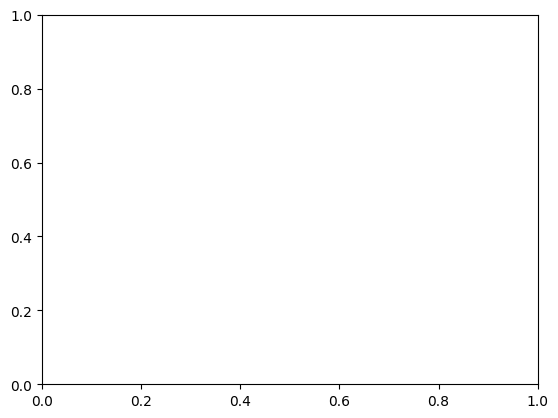

In [22]:
fig, ax  = subplots()
ax = summary_plot(hit_results,ax,col='mae',ylabel='MAE',valid_legend='Validation(=Test)')
ax.set_ylim([0,400])
ax.set_xticks(np.linspace(0,50,11).astype(int))

In [26]:
hit_model.eval() #Sets model as trained. here turns off the dropout layers which are useful only for regularization
preds = hit_module(X_test_t)
torch.abs(Y_test_t-preds).mean()

tensor(202.9220, grad_fn=<MeanBackward0>)

In [27]:
#Clean up
del(Hitters, hit_model,hit_dm,hit_logger,hit_test,hit_train,X,Y,X_test,X_train,Y_test,Y_train,X_test_t,Y_test_t,hit_trainer,hit_module)

In [28]:
#MNIST

In [11]:
(mnist_train,mnist_test) = [MNIST(root='data',train=train,download=True,transform=ToTensor()) for train in [True,False]]
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
#ToTensor rescales to 0-1 and reordes axes

In [12]:
mnist_dm = SimpleDataModule(mnist_train,mnist_test,validation=0.2,num_workers=max_num_workers,batch_size=128) #had to drop batch_size due to limited 

In [13]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel,self).__init__()
# Flatten, go to vector of 256 dimensions, ReLU activation, remove 40%        
        self.layer1 = nn.Sequential(nn.Flatten(),nn.Linear(28*28,256),nn.ReLU(),nn.Dropout(0.4))
# Go to vector of 128 dimensions, ReLU activation, remove 30%        
        self.layer2 = nn.Sequential(nn.Linear(256,128),nn.ReLU(),nn.Dropout(0.3))
# Finally Map 128 to 10 outputs        
        self._forward = nn.Sequential(self.layer1,self.layer2,nn.Linear(128,10))

    def forward(self,x):
        return self._forward(x)

In [14]:
mnist_model = MNISTModel()

In [15]:
X_ = torch.tensor(np.zeros((256,1,28,28)).astype(np.float32))
summary(mnist_model,input_data=X_,col_names=['input_size','output_size','num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [16]:
mnist_module = SimpleModule.classification(mnist_model,10) # Uses cross-entropy had to add 10 for # of classifers, not in book
mnist_logger = CSVLogger('logs',name='MNIST')

In [18]:
mnist_trainer = Trainer(deterministic=True,max_epochs=30,logger=mnist_logger,callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,datamodule=mnist_dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\luisn\.conda\envs\islp\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory logs\MNIST\version_2\checkpoints exists and is not empty.

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████| 375/375 [00:05<00:00, 74.09it/s, v_num=2]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████| 375/375 [00:04<00:00, 75.12it/s, v_num=2]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████| 375/375 [00:05<00:00, 73.17it/s, v_num=2]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████| 375/375 [00:04<00:00, 76.21it/s, v_num=2]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████| 375/375 [00:04<00:00, 76.14it/s, v_num=2]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████████████| 375/375 [00:04<00:00, 76.02it/s, v_num=2]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████████████| 375/375 [00:04<00:00, 76.88it/s, v_num=2]
idation: |                    

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|█████████████████| 375/375 [00:05<00:00, 65.93it/s, v_num=2]


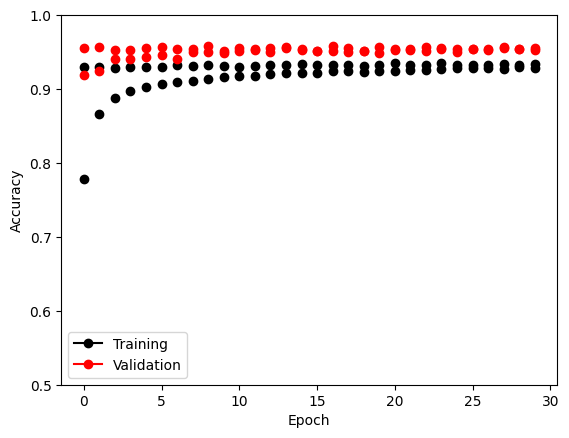

In [23]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = subplots()
summary_plot(mnist_results,ax,col='accuracy',ylabel='Accuracy')
ax.set_ylim([0.5,1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0,30,7).astype(int))

In [25]:
mnist_trainer.test(mnist_module,datamodule=mnist_dm)

Testing DataLoader 0: 100%|███████████████| 79/79 [00:00<00:00, 167.68it/s]
────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9591000080108643
        test_loss           0.26341286301612854
────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.26341286301612854, 'test_accuracy': 0.9591000080108643}]

In [29]:
# Clean up
del(mnist_test,mnist_train,mnist_model,mnist_dm,mnist_trainer,mnist_module,mnist_results)

In [31]:
#CNN

(cifar_train,cifar_test) = [CIFAR100(root='data',train=train,download=True) for train  in [True, False]]

100%|███████████████████████████████████| 169M/169M [00:40<00:00, 4.19MB/s]


In [32]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in cifar_test.data])

cifar_train = TensorDataset(cifar_train_X,torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,torch.tensor(cifar_test.targets))

In [33]:
cifar_dm = SimpleDataModule(cifar_train,cifar_test,validation=0.2,num_workers=max_num_workers,batch_size=64)

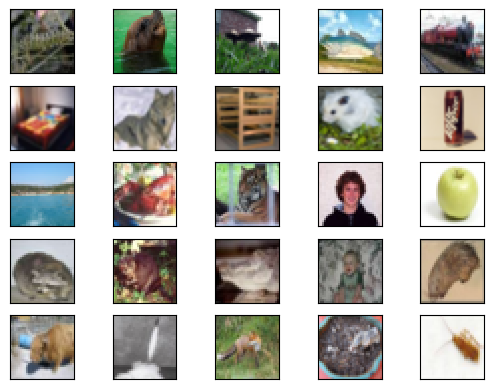

In [36]:
fig, axes = subplots(5,5)
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)),25,replace=False).reshape((5,5))

for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],[1,2,0]),interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

In [43]:
# Define CNN layer

class BuildingBlock(nn.Module):

    def __init__(self,in_channels,out_channels):
        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=(3,3),padding='same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))

    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

In [44]:
class CIFARModel(nn.Module):

    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3,32),(32,64),(64,128),(128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_,out_) for in_, out_ in sizes])
        self.output = nn.Sequential(nn.Dropout(0.5),nn.Linear(2*2*256,512),nn.ReLU(),nn.Linear(512,100))

    def forward(self,x):
        val = self.conv(x)
        val = torch.flatten(val,start_dim=1)
        return self.output(val)

In [45]:
cifar_model = CIFARModel()
summary(cifar_model,input_data=torch.tensor(np.zeros((128,3,32,32)).astype(np.float32)),col_names=['input_size','output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

In [47]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)
cifar_module = SimpleModule.classification(cifar_model,100,optimizer=cifar_optimizer)
cifar_logger = CSVLogger('logs',name='CIFAR100')

In [48]:
cifar_trainer = Trainer(deterministic=True,max_epochs=30,logger=cifar_logger,callbacks=[ErrorTracker()])
cifar_trainer.fit(cifar_module,datamodule=cifar_dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████| 625/625 [00:39<00:00, 15.94it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████| 625/625 [00:39<00:00, 15.83it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████| 625/625 [00:42<00:00, 14.65it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████| 625/625 [00:43<00:00, 14.38it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████| 625/625 [00:43<00:00, 14.52it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████████████| 625/625 [00:41<00:00, 15.10it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████████████| 625/625 [00:41<00:00, 14.94it/s, v_num=0]
idation: |                    

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|█████████████████| 625/625 [00:44<00:00, 13.98it/s, v_num=0]


(0.0, 1.0)

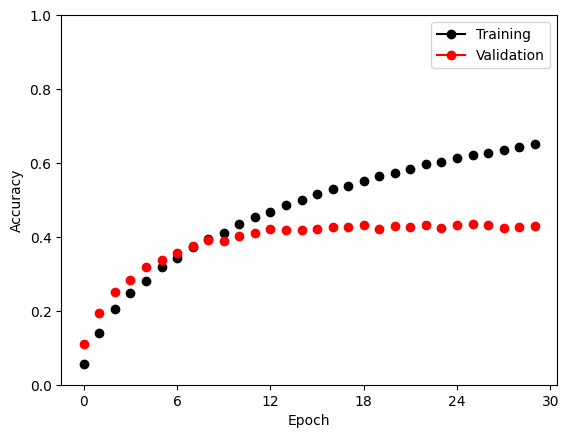

In [50]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)

fig,ax = subplots()
summary_plot(cifar_results,ax,col='accuracy',ylabel='Accuracy')
ax.set_xticks(np.linspace(0,30,6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])

In [52]:
cifar_trainer.test(cifar_module,datamodule=cifar_dm)

Testing DataLoader 0: 100%|██████████████| 157/157 [00:04<00:00, 38.19it/s]
────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4343000054359436
        test_loss           2.3719844818115234
────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.3719844818115234, 'test_accuracy': 0.4343000054359436}]

In [56]:
#Clean up
del(cifar_test,cifar_train,cifar_dm,cifar_module,cifar_logger,cifar_optimizer,cifar_trainer)

In [57]:
#IMDB

In [60]:
(imdb_seq_train,imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample>0][:12]
sample_review[:12]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468], dtype=int32)

In [61]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

Retrieving "IMDB_word_index.pkl" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


"<START> this film was just brilliant casting location scenery story direction everyone's"

In [62]:
max_num_workers=10
(imdb_train,imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train,imdb_test,validation =2000,num_workers=min(6,max_num_workers),batch_size=256)

Retrieving "IMDB_X_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [65]:
class IMDBModel(nn.Module):

    def __init__(self,input_size):
        super(IMDBModel,self).__init__()
        self.dense1 = nn.Linear(input_size,16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16,16)
        self.output = nn.Linear(16,1)

    def forward(self,x):
        val = x
        for _map in [self.dense1,self.activation,self.dense2,self.activation,self.output]:
            val = _map(val)
        return torch.flatten(val)

In [66]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,input_size=imdb_test.tensors[0].size(),col_names=['input_size','output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

In [68]:
imdb_optimizer = RMSprop(imdb_model.parameters(),lr=0.001)
imdb_module = SimpleModule.binary_classification(imdb_model,optimizer=imdb_optimizer)

In [69]:
imdb_logger = CSVLogger('logs',name='IMDB')
imdb_trainer = Trainer(deterministic=True,max_epochs=30,logger=imdb_logger,callbacks=[ErrorTracker()])

imdb_trainer.fit(imdb_module,datamodule=imdb_dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | IMDBModel         | 160 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|████████████████████| 90/90 [00:04<00:00, 19.66it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████| 90/90 [00:02<00:00, 44.55it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████| 90/90 [00:01<00:00, 48.39it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|████████████████████| 90/90 [00:01<00:00, 45.93it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|████████████████████| 90/90 [00:01<00:00, 47.50it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|████████████████████| 90/90 [00:01<00:00, 46.02it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|████████████████████| 90/90 [00:01<00:00, 47.25it/s, v_num=0]
idation: |                    

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|███████████████████| 90/90 [00:02<00:00, 43.25it/s, v_num=0]


In [70]:
test_results = imdb_trainer.test(imdb_module,datamodule=imdb_dm)
test_results

Testing DataLoader 0: 100%|████████████████| 98/98 [00:01<00:00, 80.88it/s]
────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8471199870109558
        test_loss           1.5263152122497559
────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5263152122497559, 'test_accuracy': 0.8471199870109558}]

In [71]:
# Lasso Comparison
((X_train,Y_train),(X_valid,Y_valid),(X_test,Y_test)) = load_sparse(validation=2000,random_state=0,root='data/IMDB')

Retrieving "IMDB_X_test.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [74]:
lam_max = np.abs(X_train.T *(Y_train-Y_train.mean())).max()
lam_val = lam_max*np.exp(np.linspace(np.log(1),np.log(1e-4),50))

In [77]:
logit = LogisticRegression(penalty='l1',C=1/lam_max,solver='liblinear',warm_start=True,fit_intercept=True)

In [78]:
coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train,Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

In [79]:
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

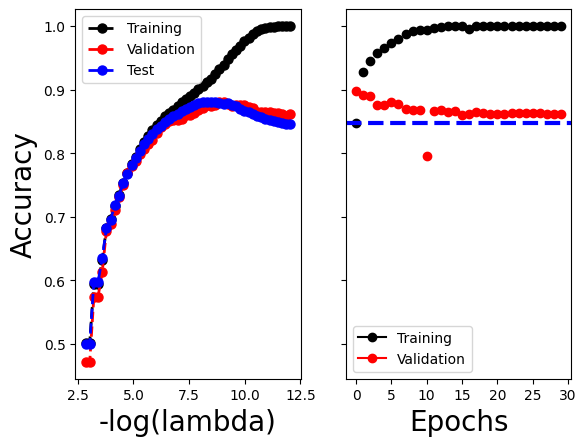

In [85]:
fig,axes = subplots(1,2,sharey=True)
for ((X_,Y_), data_,color) in zip([(X_train,Y_train),(X_valid,Y_valid),(X_test,Y_test)],['Training','Validation','Test'],
                                 ['black','red','blue']):
    linpred_ = X_*coefs.T+intercepts[None,:]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_==l) for l in label_.T])
    axes[0].plot(-np.log(lam_val/X_train.shape[0]),accuracy_,'.--',color=color,markersize=13,linewidth=2,label=data_)
axes[0].legend()
axes[0].set_xlabel(r'-log(lambda)',fontsize=20)
axes[0].set_ylabel('Accuracy',fontsize=20)

imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results,axes[1],col='accuracy',ylabel='Accuracy')
axes[1].set_xticks(np.linspace(0,30,7).astype(int))
axes[1].set_ylabel('Accurary',fontsize=20)
axes[1].set_xlabel('Epochs',fontsize=20)
axes[1].axhline(test_results[0]['test_accuracy'],color='blue',linestyle='--',linewidth=3)


In [86]:
#Clean up
del(imdb_model,imdb_trainer,imdb_logger,imdb_dm,imdb_train,imdb_test)

In [87]:
#RNN

imdb_seq_dm = SimpleDataModule(imdb_seq_train,imdb_seq_test,validation=2000,batch_size=150,num_workers=6)

In [89]:
class LSTMModel(nn.Module):
    def __init__(self,input_size):
        super(LSTMModel,self).__init__()
        self.embedding = nn.Embedding(input_size,32)
        self.lstm = nn.LSTM(input_size=32,hidden_size=32,batch_first=True)
        self.dense = nn.Linear(32,1)
    def forward(self,x):
        val,(h_n,c_n) = self.lstm(self.embedding(x))
        return torch.flatten(self.dense(val[:,-1]))

In [90]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model,input_data=imdb_seq_train.tensors[0][:10],col_names=['input_size','output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

In [92]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs',name="IMDB_LSTM")

lstm_trainer = Trainer(deterministic=True,max_epochs=20,logger=lstm_logger,callbacks=[ErrorTracker()])
lstm_trainer.fit(lstm_module,datamodule=imdb_seq_dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | LSTMModel         | 328 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████████████| 154/154 [00:18<00:00,  8.21it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████| 154/154 [00:18<00:00,  8.26it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████| 154/154 [00:18<00:00,  8.11it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████| 154/154 [00:18<00:00,  8.19it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████| 154/154 [00:18<00:00,  8.14it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████████████| 154/154 [00:18<00:00,  8.11it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████████████| 154/154 [00:19<00:00,  8.06it/s, v_num=0]
idation: |                    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█████████████████| 154/154 [00:19<00:00,  7.78it/s, v_num=0]


In [93]:
lstm_trainer.test(lstm_module,datamodule=imdb_seq_dm)

Testing DataLoader 0: 100%|██████████████| 167/167 [00:04<00:00, 36.28it/s]
────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8504400253295898
        test_loss           0.7439918518066406
────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7439918518066406, 'test_accuracy': 0.8504400253295898}]

(0.5, 1.0)

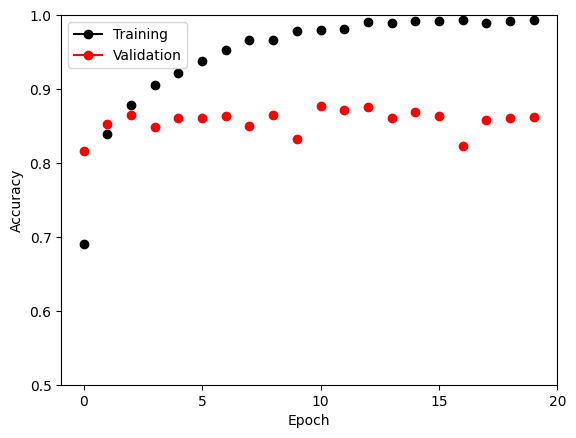

In [95]:
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig, ax = subplots()
summary_plot(lstm_results,ax,col='accuracy',ylabel='Accuracy')
ax.set_xticks(np.linspace(0,20,5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5,1])

In [100]:
#Time series

In [117]:
NYSE = load_data('NYSE')
cols = ['DJ_return','log_volume','log_volatility']
X = pd.DataFrame(StandardScaler(with_mean=True,with_std=True).fit_transform(NYSE[cols]),columns=NYSE[cols].columns,index=NYSE.index)

In [118]:
for lag in range(1,6):
    for col in cols:
        newcol = np.zeros(X.shape[0])*np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns),"{0}_{1}".format(col,lag),newcol)
X.insert(len(X.columns),'train',NYSE['train'])
X = X.dropna()

In [119]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [112]:
M = LinearRegression()
M.fit(X[train],Y[train])
M.score(X[~train],Y[~train])

0.41289129385625223

In [123]:
NYSE['day_of_week']

date
1962-12-03     mon
1962-12-04    tues
1962-12-05     wed
1962-12-06    thur
1962-12-07     fri
              ... 
1986-12-24     wed
1986-12-26     fri
1986-12-29     mon
1986-12-30    tues
1986-12-31     wed
Name: day_of_week, Length: 6051, dtype: category
Categories (5, object): ['mon', 'tues', 'wed', 'thur', 'fri']

In [124]:
X_day = pd.merge(X,pd.get_dummies(NYSE['day_of_week']),on='date') #Not sure why this fails?

InvalidIndexError: slice(None, None, None)

In [127]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col,lag))
X = X.reindex(columns=ordered_cols)       
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [128]:
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

In [129]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel,self).__init__()
        self.rnn = nn.RNN(3,12,batch_first=True)
        self.dense = nn.Linear(12,1)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self,x):
        val,h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1]))
        return torch.flatten(val)

nyse_model = NYSEModel()

In [133]:
datasets = []
for mask in [train,~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32)) # should be replaced with iloc in future
    datasets.append(TensorDataset(X_rnn_t,Y_t))

nyse_train, nyse_test = datasets

C:\Users\luisn\AppData\Local\Temp\ipykernel_14376\3289109364.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32)) # should be replaced with iloc in future
C:\Users\luisn\AppData\Local\Temp\ipykernel_14376\3289109364.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32)) # should be replaced with iloc in future


In [135]:
summary(nyse_model,input_data=X_rnn_t,col_names=['input_size','output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

In [136]:
nyse_dm = SimpleDataModule(nyse_train,nyse_test,num_workers=4,validation=nyse_test,batch_size=64)

In [138]:
for idx, (x,y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(),out.size())
    if idx >=2:
        break

torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


In [139]:
nyse_optimizer = RMSprop(nyse_model.parameters(),lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,optimizer=nyse_optimizer,metrics={'r2':R2Score()})

In [ ]:
nyse_trainer = Trainer(deterministic=True,max_epochs=200,callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,datamodule=nyse_dm)
nyse_trainer.test(nyse_module,datamodule=nyse_dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\luisn\.conda\envs\islp\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 217    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
217       Trai

Epoch 0: 100%|████████████████████| 67/67 [00:04<00:00, 16.65it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████| 67/67 [00:00<00:00, 86.60it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████| 67/67 [00:00<00:00, 89.34it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|████████████████████| 67/67 [00:00<00:00, 82.21it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|████████████████████| 67/67 [00:00<00:00, 92.25it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|████████████████████| 67/67 [00:00<00:00, 90.87it/s, v_num=0]
idation: |                                        | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|████████████████████| 67/67 [00:00<00:00, 83.21it/s, v_num=0]
idation: |                    